# F500 PlantEye data processing

This notebooks shows how to process the F500 data using the ISA-JSON file.

## Setup

Read packages and the ISA-JSON with all the project meta.
Please set `threshold_date` to the start of the experiment. In some case there were trial measurements which you don't need to use your analysis.

In [78]:

import json
import os
from isatools.isajson import ISAJSONEncoder
import isatools
from isatools.model import *
from isatools import isajson

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import seaborn as sns
import datetime as dt
from PIL import Image

isa_json = "/data2/npec/notebook_data/NPEC_Potdata_Gantry3_exp29_running.csv.json"
metadata_file = "/data2/npec/notebook_data/running_exp29_Gantry3/exp29/metadata/NPEC_Potdata_Gantry3_exp29_running.csv"
data_folder = "/data2/npec/notebook_data/"
threshold_date = dt.datetime(2021, 1, 1)


investigation = isajson.load(open(isa_json, "r"))
study = investigation.studies[0]

# @TODO: this needs to be added to the JSON as data file to the study
metadata = pd.read_csv(metadata_file, delimiter = ";", engine = "python")
metadata[['Pot']] = metadata['DataMatrix'].str.split(" ", expand=True)
metadata = metadata.drop('DataMatrix', axis=1)


## Phenotopic data

Read all phenotypic data into a single pandas dataframe. 

In [2]:
phenotypic_data_list = []
for assay in study.assays:
    sample_name = assay.samples[0].name
    timepoint = assay.filename
    title = assay.filename

    for df in assay.data_files:
        for com in df.comments:
            if com.name == "fullPath" and "/" + title + ".csv" in com.value:
                assay_data = pd.read_csv(data_folder + com.value, header=0, delimiter=";")
                phenotypic_data_list.append(assay_data)
                    
phenotypic_data = pd.concat(phenotypic_data_list, axis=0, ignore_index=True)

phenotypic_data = pd.merge(phenotypic_data, metadata, on='Pot')

## Formatting data

In [3]:
def concatenate_columns(row, x, y):
    return f"{row[x]}, {row[y]}"

phenotypic_data["Treatment"] = phenotypic_data["Treatment_y"]
phenotypic_data["timestamp"]= phenotypic_data["timestamp"].apply(lambda x: dt.datetime.strptime(x, '%Y%m%dT%H%M%S'))
phenotypic_data["day"] = phenotypic_data["timestamp"].dt.date
phenotypic_data['timestamp_hourly'] = phenotypic_data['timestamp'].dt.floor('h')
phenotypic_data = phenotypic_data[phenotypic_data["timestamp"] >= threshold_date]

phenotypic_data["Treatment, genotype"] =  phenotypic_data.apply(concatenate_columns, axis=1, x='Treatment', y='Genotype')

## Summary of the data

In [4]:
print(f'Number of data points: {len(phenotypic_data["timestamp"])}')
print(f'Number of different genotypes: {len(phenotypic_data["Genotype"].unique())}')
print(f'List of genotypes: {phenotypic_data["Genotype"].unique()}')
print(f'Maximum height: {max(phenotypic_data["height_max"].dropna())}')
print(f'Minimum maximum height: {min(phenotypic_data["height_max"].dropna())}')
print(f'Average maximum height: {np.mean(phenotypic_data["height_max"].dropna())}')
print(f'Treatments: {phenotypic_data["Treatment"].unique()}')
print(f'Start date: {sorted(phenotypic_data["timestamp"])[0]}')
print(f'End date: {sorted(phenotypic_data["timestamp"])[-1]}')
print(f'Samples: {phenotypic_data["Pot"].unique()}')

Number of data points: 348
Number of different genotypes: 2
List of genotypes: ['G1' 'G2']
Maximum height: 408.753
Minimum maximum height: 0.0
Average maximum height: 238.17170689655174
Treatments: ['T1' 'T2']
Start date: 2023-06-23 10:04:37
End date: 2023-07-09 12:03:35
Samples: ['GJ1' 'GJ2' 'GJ3' 'GJ4' 'GJ5' 'GJ6' 'GJ7' 'GJ8' 'GJ9' 'GJ10' 'GJ11'
 'GJ12']


## Plotting functions

In [6]:
def plotGenotypes(Experiment, Genotypes, hue="Genotype"):
    Genotypes = list(Genotypes)

    traits = ["digital_biomass", "height", "leaf_inclination", "leaf_angle"]
    filtered = Experiment[Experiment['Genotype'].isin(Genotypes)]

    for trait in traits:
        sns.lineplot(
            data=filtered,
            x="timestamp_hourly",
            y=trait,
            hue=hue,
            palette="colorblind"
        )
        plt.title(f"Plant {trait.replace('_', ' ')}, colored by {hue}")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

def plotTreatment(Experiment, Treatment, hue="Pot"):
    Treatment = list(Treatment)  # ensure it's 1D

    for trait in ["digital_biomass", "height", "leaf_inclination", "leaf_angle"]:
        sns.lineplot(
            data=Experiment[Experiment['Treatment'].isin(Treatment)],
            x="timestamp_hourly",
            y=trait,
            hue=hue,
            palette="colorblind"
        )
        plt.title(f"Plant {trait.replace('_', ' ')}, colored by {hue}")
        plt.xticks(rotation=90)
        plt.show()



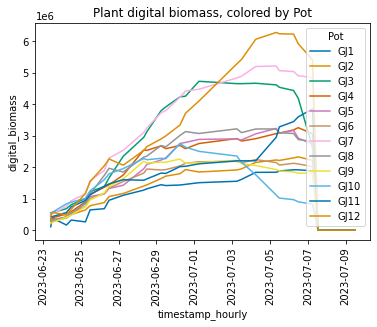

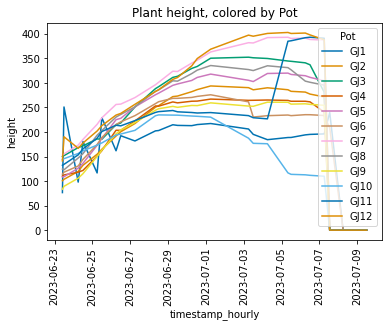

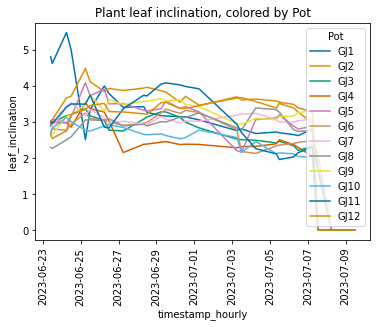

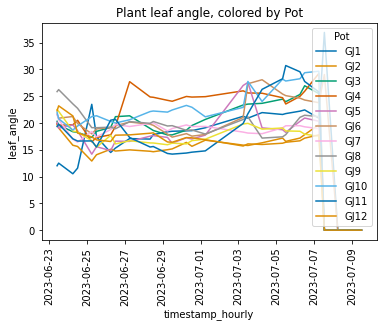

In [7]:
plotTreatment(phenotypic_data, phenotypic_data["Treatment"].unique(), hue="Pot")

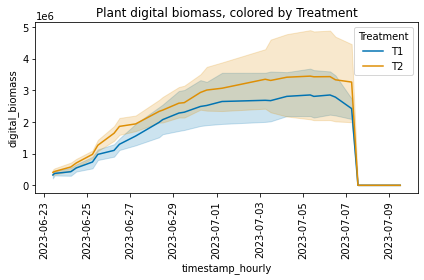

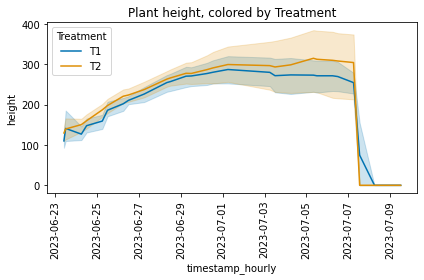

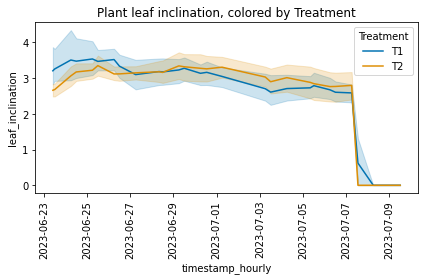

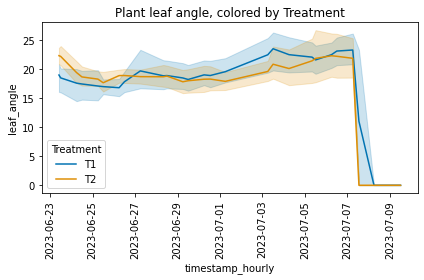

In [8]:
plotGenotypes(phenotypic_data, phenotypic_data["Genotype"].unique(), hue="Treatment")

## Histogram data

Index options: greenness, ndvi, psri, hue and npci 

In [79]:
def get_histogram(index = "greenness", sample = None):
    histogram_list = []
    for assay in study.assays:
        sample_name = assay.samples[0].name
        timepoint = assay.filename
        if sample != None:
            if sample_name != sample:
                continue
        for df in assay.data_files:
            for com in df.comments:
                if com.name == "fullPath" and "_" + index + ".csv" in com.value:
                    histogram_file =  data_folder + com.value
                    try:
                        histogram_data = pd.read_csv(histogram_file, sep=";")
                        if len(histogram_list) > 0:
                            histogram_data = histogram_data[histogram_data["sample"] != "edges"]
                        histogram_list.append(histogram_data) 
                    except Exception as e:
                        #print("Could not process histogram file: {}".format(e))
                        pass
    histogram = pd.DataFrame()
    if len(histogram_list) == 0:
        print("No histogram data found")
    else:
        histogram = pd.concat(histogram_list, axis=0, ignore_index=True)
        histogram["timepoint"]= histogram["timepoint"].apply(lambda x: dt.datetime.strptime(x, '%Y%m%dT%H%M%S'))
        histogram["day"] = histogram["timepoint"].dt.date
        # rename bin column names
        xAxis = histogram[histogram["sample"] == "edges"]
        xAxis = xAxis.drop(columns=["day", "timepoint", "sample"])
        xAxis = xAxis.loc[0, :].values.flatten().tolist()
        columns = {}
        for c in range(0,257):
            columns["bin{}".format(c)] = xAxis[c]
        histogram = histogram.rename(columns=columns)

    return histogram

def plotHistogram(sample, index):
    sample_melt = sample.melt(id_vars=["sample", "day", "timepoint"])
    minDate = min(sample_melt["day"])
    maxDate = max(sample_melt["day"])

    #print(minDate)
    #print(maxDate)

    #Normalize by total count for each day
    sample_melt['total_count'] = sample_melt.groupby('day')['value'].transform('sum')  # Total greenness values per day
    sample_melt['value_normalized'] = sample_melt['value'] / sample_melt['total_count']  # Normalize greenness

    # Plot the normalized values
    ax = sns.lineplot(data=sample_melt[(sample_melt["day"] == minDate) | (sample_melt["day"] == maxDate)],
                    x="variable", y="value_normalized", hue="day")
    #ax = sns.lineplot(data = sample_melt[(sample_melt["day"] == minDate) | (sample_melt["day"] == maxDate)], x="variable", y="value", hue="day")
    plt.xticks(rotation=90)
    plt.title("{} for {}".format(index, sample_name))
    plt.xlabel(index)
    plt.ylabel("Count")
    plt.show()

## Index plots

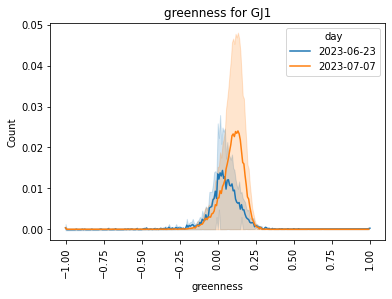

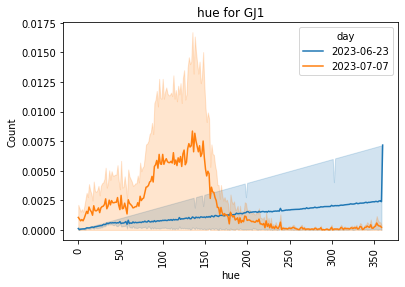

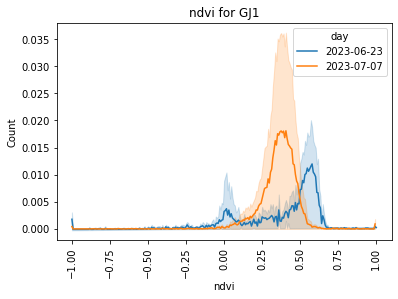

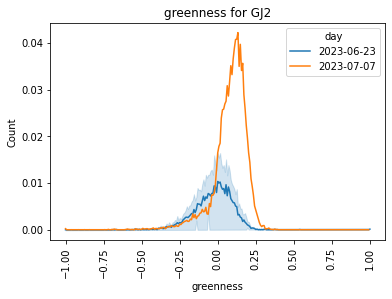

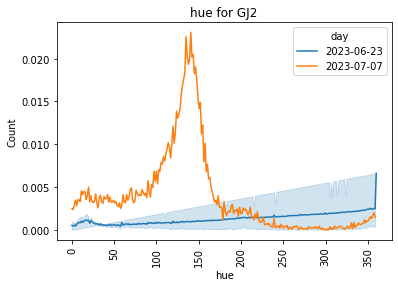

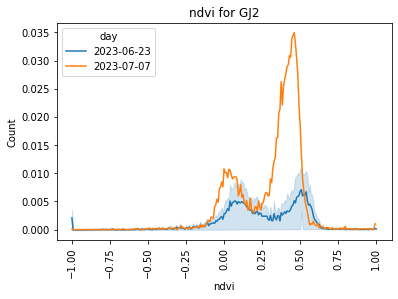

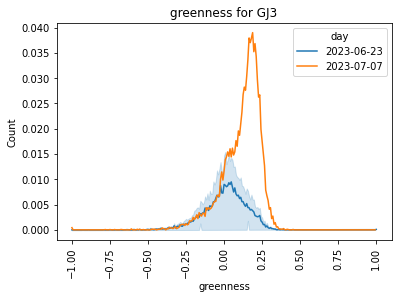

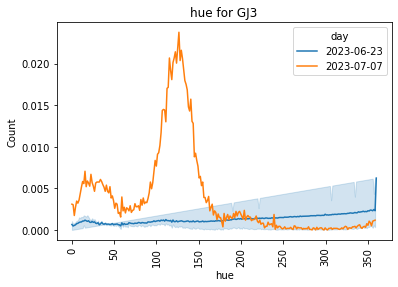

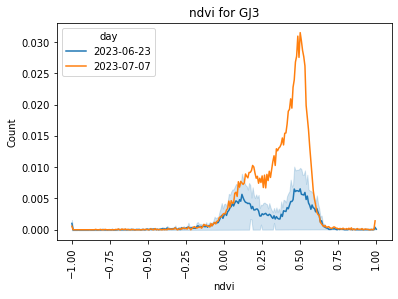

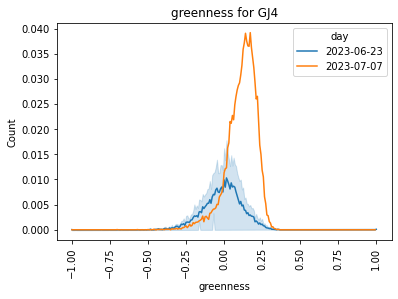

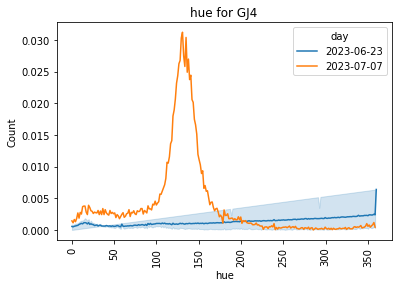

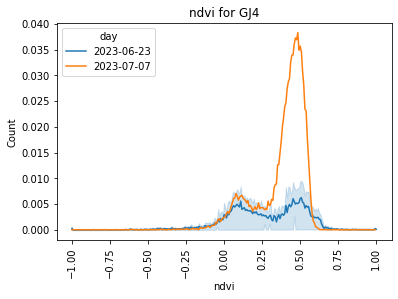

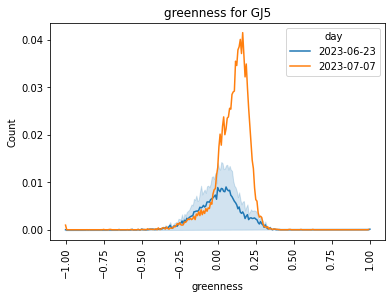

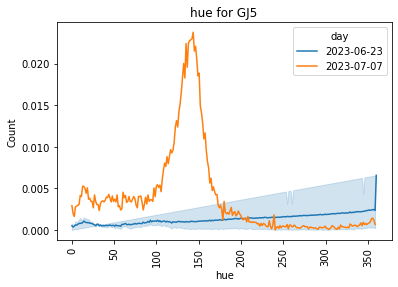

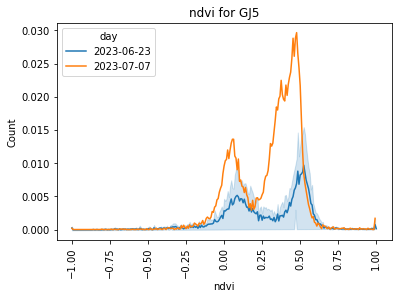

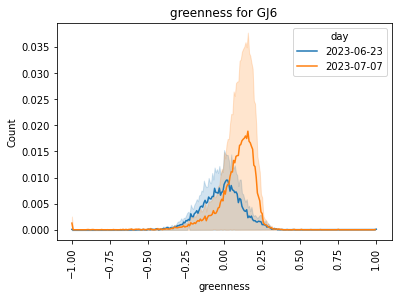

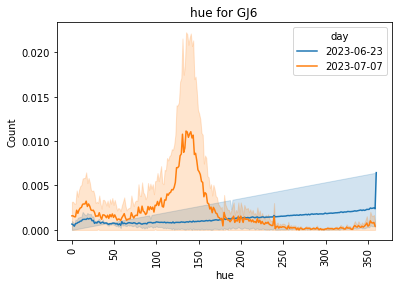

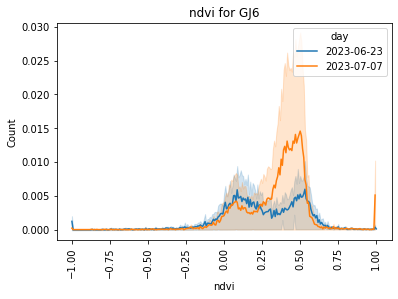

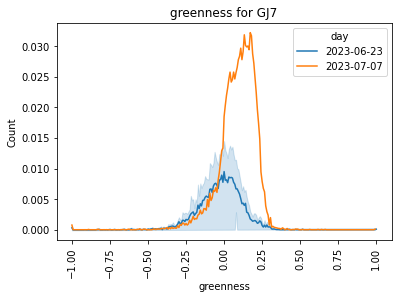

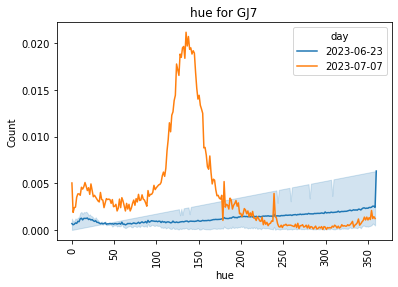

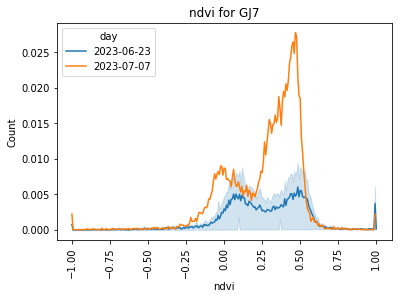

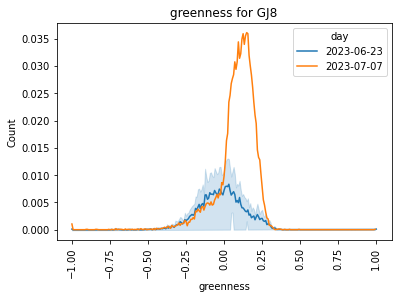

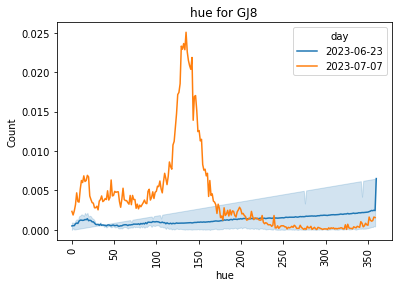

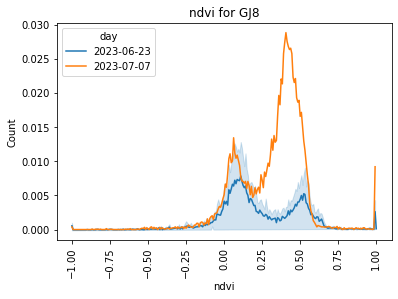

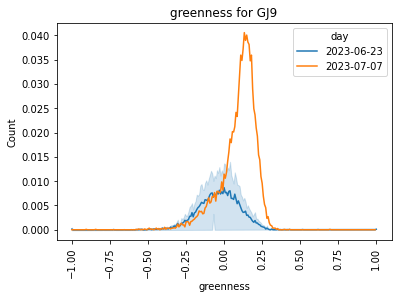

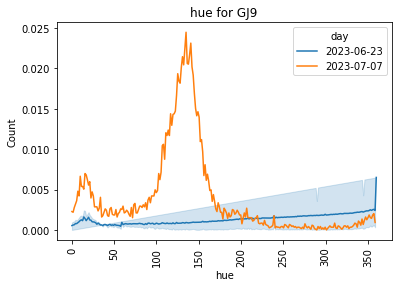

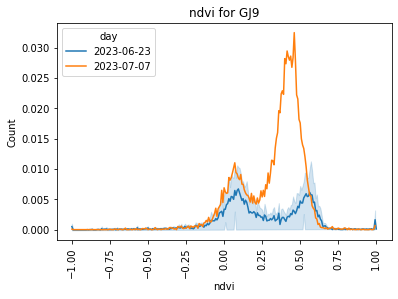

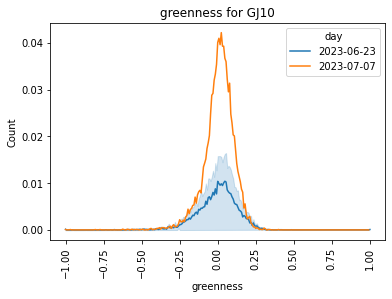

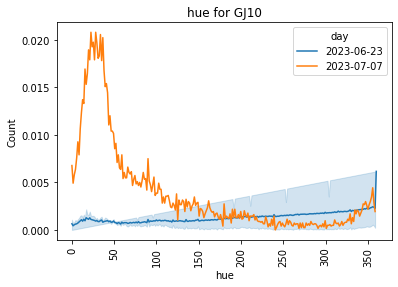

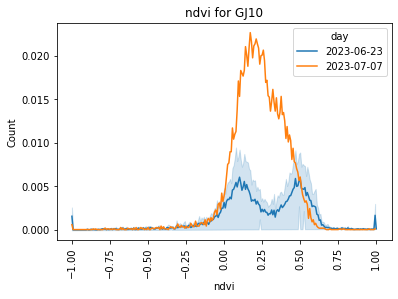

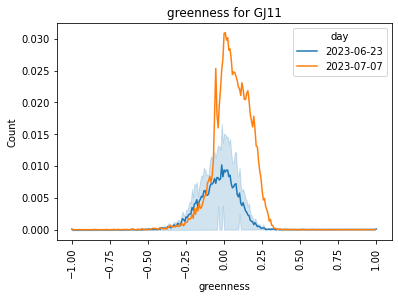

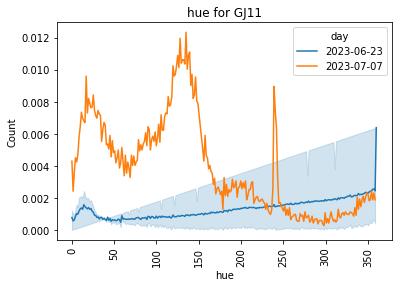

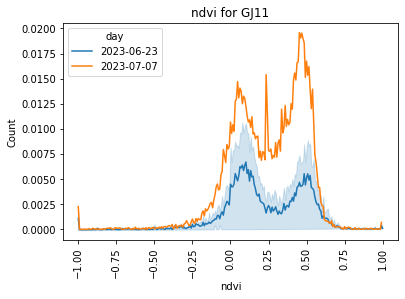

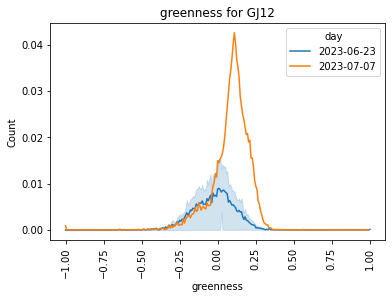

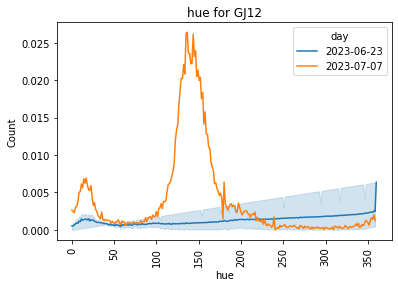

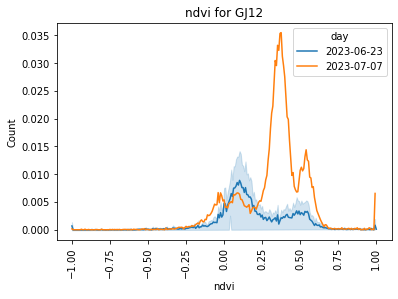

In [44]:
for sample_name in phenotypic_data["Pot"].unique():
    for index in ["greenness", "hue", "ndvi"]:
        sample = get_histogram(index, sample_name)
        plotHistogram(sample, index)




## Overview of top view images

In [87]:
def get_images(type = "RGB", sample = None):
    image = pd.DataFrame(columns=["date", "name"])
    for assay in study.assays:
        sample_name = assay.samples[0].name
        timepoint = assay.filename
        extension = ".png"
        if type in ["NDVI", "ndvi"]:
            extension = ".ndvi.PNG"
        if sample != None:
            if sample_name != sample:
                continue
        for df in assay.data_files:
            for com in df.comments:
                if "ply.gz" in com.value and "full" in com.value:
                    new_row = pd.DataFrame([{
                        "date": timepoint,
                        "name": data_folder + com.value + extension}])

                    image = pd.concat([image, new_row], ignore_index=True)
                    #print("Found image file: {}".format(com.value))
    image = image[image["name"].apply(lambda x: os.path.exists(x))].reset_index(drop=True)
    # Convert 'date' column to datetime for sorting
    image['date'] = pd.to_datetime(image['date'], format='%Y%m%dT%H%M%S')

    # Sort the dataframe by date
    image = image.sort_values(by='date')

    # Extract all the file names
    image_files = image['name'].tolist()


    max_cols = 5
    num_images = len(image_files)

    # Calculate number of rows needed
    rows = math.ceil(num_images / max_cols)
    cols = min(num_images, max_cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    # If there's only 1 row, axes is 1D; make it 2D for consistency
    if rows == 1:
        axes = [axes]

    # Flatten axes to 1D list for easy indexing
    axes_flat = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

    # Display images
    for i, ax in enumerate(axes_flat):
        if i < num_images:
            img = Image.open(image_files[i])
            img.thumbnail((200, 200))
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplot axes

    plt.tight_layout()
    plt.show()


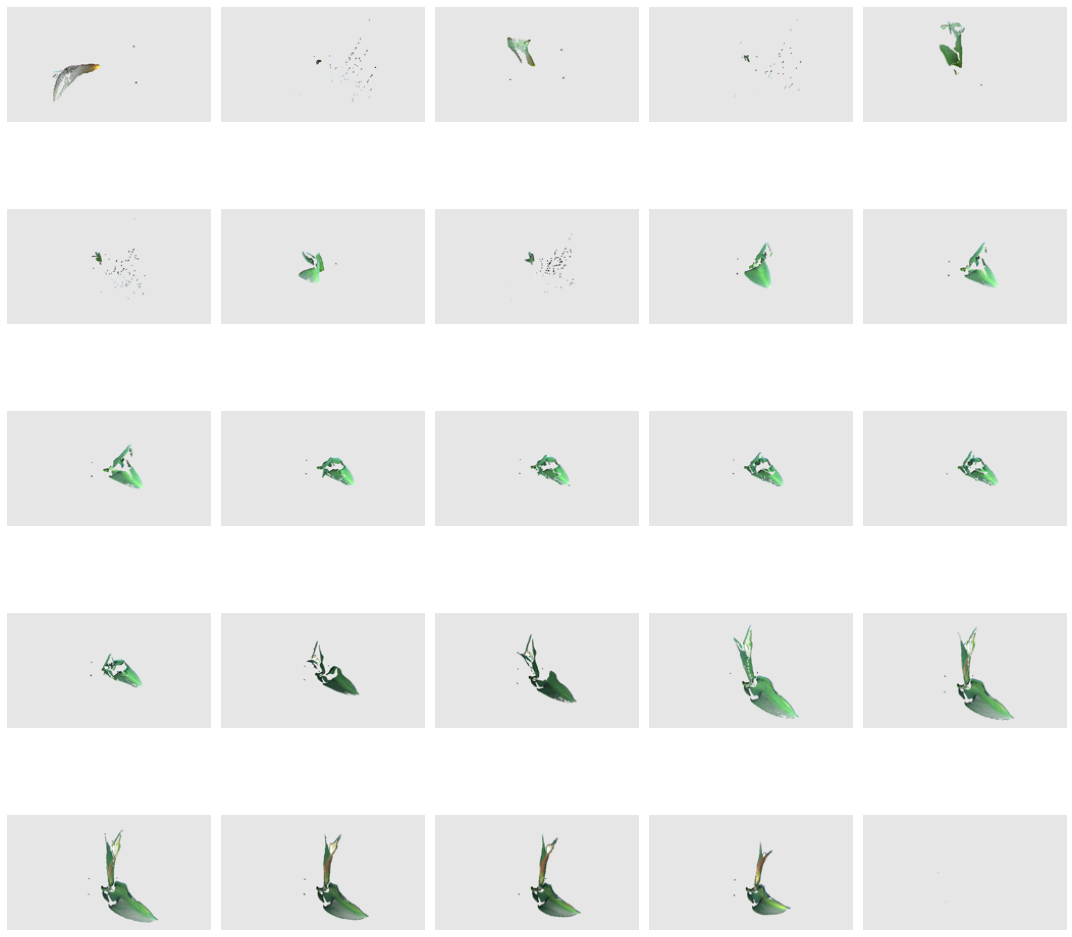

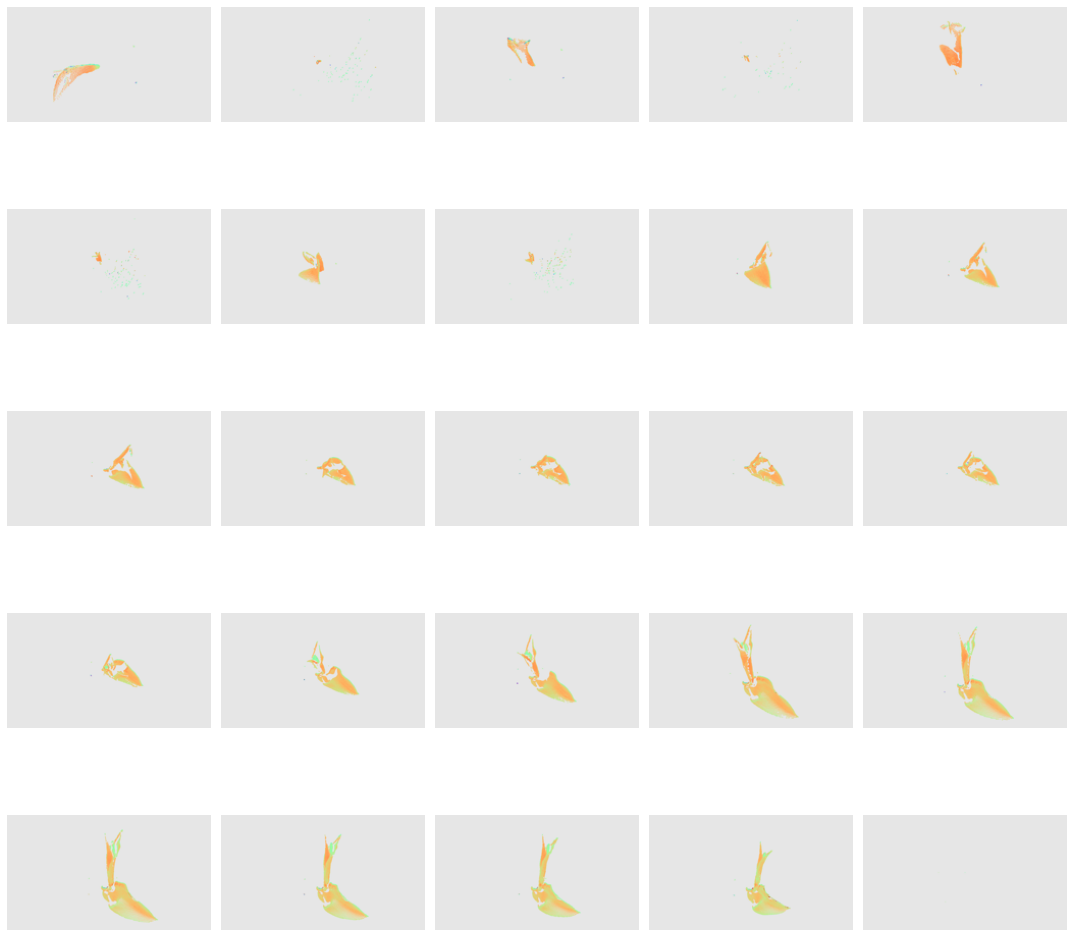

In [89]:
get_images("RGB",  "GJ1")
get_images("ndvi",  "GJ1")

## Vigor

In [ ]:
# Sample to calculate vigor for
sample = "GJ1"

# Filter data for the specific sample and sort by 'timestamp'
vigor = phenotypic_data[phenotypic_data['Pot'] == sample].sort_values(by=['Pot', 'timestamp'])

# Define the time interval for interpolation (e.g., every 1 hour)
resample_interval = '12h'  # or '6H', '12H', etc. depending on the desired frequency

# Function to interpolate biomass for a single sample
def interpolate_biomass(df):
    # Set 'timestamp' as the index to allow resampling
    df = df.set_index('timestamp')

    # Resample biomass at the defined interval and interpolate missing values
    resampled_df = df[['digital_biomass']].resample(resample_interval).mean()  # Resample every X hours

    # Interpolate only the 'digital_biomass' column
    resampled_df['digital_biomass'] = resampled_df['digital_biomass'].interpolate(method='polynomial', order=3)
    resampled_df['digital_biomass'] = resampled_df['digital_biomass'].rolling(window=5, min_periods=1).mean()

    # Forward fill 'Pot' (non-numeric column)
    resampled_df['Pot'] = df['Pot'].ffill()

    # Reset index to return to the original structure
    return resampled_df.reset_index()

# Directly apply interpolation without using apply() (since we're working with a single sample)
df_interpolated = interpolate_biomass(vigor)

# Calculate the time difference (in hours) between consecutive time points
df_interpolated['time_change'] = df_interpolated['timestamp'].diff().dt.total_seconds() / 3600.0

# Calculate the biomass change
df_interpolated['biomass_change'] = df_interpolated['digital_biomass'].diff()
df_interpolated['biomass_change'] = df_interpolated['biomass_change'].interpolate(method='polynomial', order=3)
df_interpolated['biomass_change'] = df_interpolated['biomass_change'].rolling(window=5, min_periods=1).mean()

# Calculate vigor (biomass change per hour)
df_interpolated['vigor'] = df_interpolated['biomass_change'] / df_interpolated['time_change']

# Drop NaN values created by diff() in the first row
df_interpolated = df_interpolated.dropna(subset=['time_change', 'biomass_change'])

# Plot the vigor over time for the sample
plt.plot(df_interpolated['timestamp'], df_interpolated['vigor'], label=sample)
plt.xlabel('Date')
plt.ylabel('Vigor (digital biomass change per hour)')
plt.title(f'Vigor Over Time for Sample {sample}')
plt.legend(title='Sample')
plt.show()

# Plot the biomass over time for the sample
plt.plot(df_interpolated['timestamp'], df_interpolated['digital_biomass'], label=sample)
plt.xlabel('Date')
plt.ylabel('Digital biomass')
plt.title(f'Digital biomass over time {sample}')
plt.legend(title='Sample')
plt.show()
